In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
import gurobipy as gp
from gurobipy import GRB

options = {
    "WLSACCESSID": "31598bc4-0b23-474f-86d4-af032d437137",
    "WLSSECRET": "bd7ad348-f8d6-452e-b615-ebc88d920e41",
    "LICENSEID": 2498404,
}

In [3]:
df = pd.read_csv('data_20180119_20180420.csv', index_col=0)
df.head()

,t0,T1,K1,C1,T2,K2,C2,S0,Adj_S0
0,2018-01-02,2018-01-19,1000.0,191.525,2018-04-20,800.0,396.725000,59.4505,1189.01001
1,2018-01-02,2018-01-19,1100.0,92.525,2018-04-20,1015.0,191.675000,59.4505,1189.01001
2,2018-01-02,2018-01-19,1150.0,46.075,2018-04-20,1025.0,183.025000,59.4505,1189.01001
3,2018-01-02,2018-01-19,1160.0,38.000,2018-04-20,1050.0,157.776341,59.4505,1189.01001
4,2018-01-02,2018-01-19,1170.0,30.450,2018-04-20,1080.0,137.850000,59.4505,1189.01001


In [4]:
t0List = list(df.t0.unique())

In [5]:
N = 20

### Linear Programming Problem
min $d+\sum_{n=1}^{N_1}\lambda_{n,1}\Pi_{n,1}+\sum_{n=1}^{N_2}\lambda_{n,2}\Pi_{n,2}$

s.t. $d+\sum_{n=1}^{N_1}\lambda_{n,1}(S_1^i-K_{n,1})^++\sum_{n=1}^{N_2}\lambda_{n,2}(S_2^j-K_{n,2})^++\Delta_{0}\cdot(S_1^i-S_0)+\Delta_{1}^i\cdot(S_2^j-S_1^i) \geq \Phi(S_1^i,S_2^j), i,j=1,...,N$

In [6]:
def payoff(S1,S2):
    return max(S2 - S1, 0)

In [7]:
parameters = {}

for t0 in t0List:
    df_t0 = df.loc[df.t0 == t0].copy()
    
    C1 = df_t0['C1']
    C2 = df_t0['C2']
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    
    S0 = df_t0['Adj_S0'].unique()
    I_ref = 50
    S1 = np.linspace(min(K1)-I_ref, max(K1)+I_ref, N)
    S2 = np.linspace(min(K2)-I_ref, max(K2)+I_ref, N)
    
    m = gp.Model("Price Bounds")
    d = m.addVars(['d'], name="d")
    lamb1 = m.addVars(df_t0.index, name="lamb1")
    lamb2 = m.addVars(df_t0.index, name="lamb2")
    delta0 = m.addVars(['delta0'], name="delta0")
    delta1 = m.addVars(np.array(S1).flatten(), name="delta1")
    
    m.setObjective(d['d']+sum(lamb1[r]*C1[r]+lamb2[r]*C2[r] for r in df_t0.index))
    m.ModelSense = GRB.MINIMIZE
    
    for S1_i in S1:
        for S2_j in S2:
            m.addConstr(d['d'] + sum(lamb1[r]*max(S1_i-K1[r],0)+lamb2[r]*max(S2_j-K2[r],0) for r in df_t0.index) + 
                        delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)
                        >= payoff(S1_i, S2_j), 'C_{}{}'.format(S1_i, S2_j))
            m.update()
    
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        var = {v.varName: v.x for v in m.getVars()}
        
        delta1_values = np.array([var['delta1[{}]'.format(s1)] for s1 in S1])
        delta1_interpolator = CubicSpline(S1, delta1_values)
        
        parameters[t0] = {
            'd': var['d[d]'],
            'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
            'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.index},
            'delta0': var['delta0[delta0]'],
            'delta1': delta1_interpolator
        }
    else:
        print("Optimization was not successful.")

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8298 nonzeros
Model fingerprint: 0xd8c37e84
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [8e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 7e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 8271 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.138158e+03   0.000000e+00      0s
      45    1.4581406e+02   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.458140635e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M

       0    0.0000000e+00   2.791842e+03   0.000000e+00      0s
      49    1.0526743e+02   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.052674339e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9379 nonzeros
Model fingerprint: 0x455e3a0f
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9379 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.210757e+03   0.000000e+00      0s
      43    1.0297310e+02   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.02

In [8]:
stocks = pd.read_csv('adjusted_stocks.csv')
realS1 = stocks.loc[stocks.Date=='2018-01-19', 'AMZN'].item()
realS2 = stocks.loc[stocks.Date=='2018-04-20', 'AMZN'].item()

In [9]:
hList = []
for t0 in t0List:
    df_t0 = df.loc[df.t0 == t0].copy()
    S0 = df_t0['Adj_S0'].unique()
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    
    h = (parameters[t0]['d']
         + sum(parameters[t0]['lamb1'][r] * max(realS1-K1[r],0) + 
               parameters[t0]['lamb2'][r] * max(realS2-K2[r],0) for r in df_t0.index)
         + parameters[t0]['delta0'] * (realS1 - S0)
         + parameters[t0]['delta1'](realS1) * (realS2-realS1)
        )
    hList.append(h)

print(hList)

[array([298.79855081]), array([277.33132367]), array([245.01554525]), array([239.24688361]), array([249.80738574]), array([260.43598588]), array([263.12007597]), array([239.77398721]), array([254.17053195]), array([249.50679195]), array([246.8811653]), array([254.3664972]), array([247.33584264])]


In [10]:
h_minus_c = np.array(hList).flatten() - payoff(realS1, realS2)
h_minus_c

array([65.88854715, 44.42132   , 12.10554159,  6.33687995, 16.89738208,
       27.52598222, 30.21007231,  6.86398355, 21.26052828, 16.59678829,
       13.97116164, 21.45649354, 14.42583898])

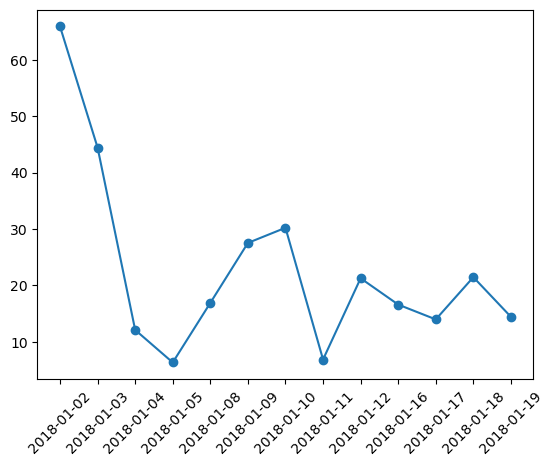

In [11]:
plt.plot(t0List, h_minus_c, '-o')
plt.xticks(rotation=45)
plt.show()

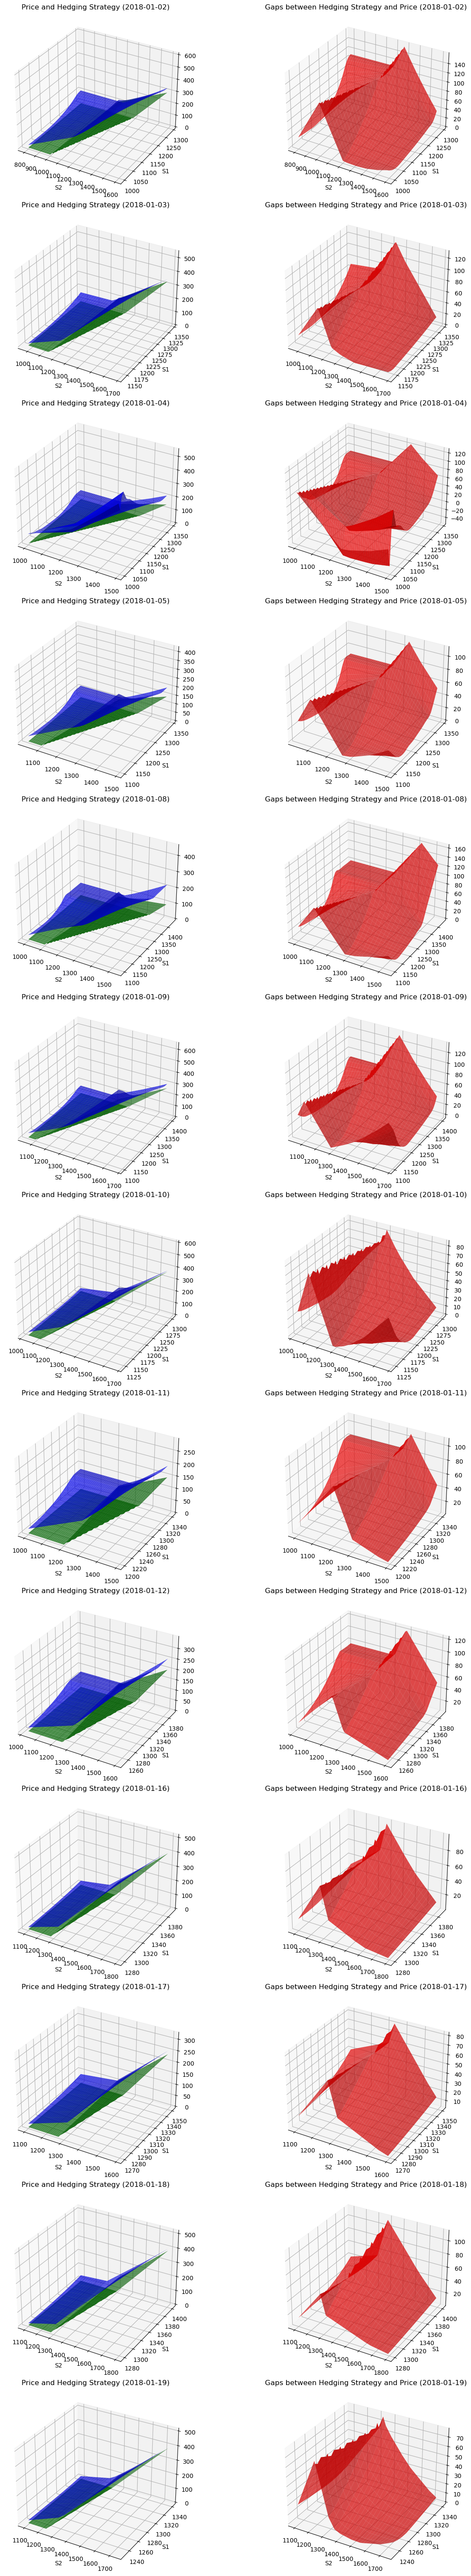

In [12]:
fig = plt.figure(figsize=(15, 60))
n_rows = len(t0List)
n_cols = 2

for k, t0 in enumerate(t0List):
    df_t0 = df.loc[df.t0 == t0].copy()
    S0 = df_t0['Adj_S0'].unique()
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    
    s1 = np.arange(min(K1), max(K1), 10)
    s2 = np.arange(min(K2), max(K2), 10)
    
    hs = np.ndarray((len(s1), len(s2)))
    cs = np.ndarray((len(s1), len(s2)))
    for i in range(len(s1)):
        for j in range(len(s2)):
            cs[i, j] = payoff(s1[i], s2[j])
            hs[i, j] = (parameters[t0]['d']
                        + sum(parameters[t0]['lamb1'][r] * max(s1[i]-K1[r],0) + 
                              parameters[t0]['lamb2'][r] * max(s2[j]-K2[r],0) for r in df_t0.index)
                        + parameters[t0]['delta0'] * (s1[i] - S0)
                        + parameters[t0]['delta1'](s1[i]) * (s2[j]-s1[i])
                       )

    ax1 = fig.add_subplot(n_rows, n_cols, k*2+1, projection='3d')
    ax2 = fig.add_subplot(n_rows, n_cols, k*2+2, projection='3d')
    x, y = np.meshgrid(s2, s1)

    ax1.plot_surface(x, y, hs, label='h', alpha=0.7, color='b')
    ax1.plot_surface(x, y, cs, label='c', alpha=0.7, color='g')
    ax1.set_xlabel('S2')
    ax1.set_ylabel('S1')
    ax1.set_title(f'Price and Hedging Strategy ({t0})')
    
    ax2.plot_surface(x, y, hs-cs, label='h-c', alpha=0.7, color='r')
    ax2.set_xlabel('S2')
    ax2.set_ylabel('S1')
    ax2.set_title(f'Gaps between Hedging Strategy and Price ({t0})')

plt.tight_layout()
plt.show()